# Relating Critics' Ratings to My Own
### Movie List Project - Notebook #2
### Max Ruther

## Motivation and Overview

In the previous notebook, I made improvements and additions to my table of movie ratings given by reviewers. With that done, I am excited to leap into some quick analysis here, to see if there are any patterns that connect my own ratings of a movie to those of the various reviewers. I plan to train a decision tree for this purpose, given its virtues in interpretability. Using the critics' ratings as predictors, it will classify whether I rated the movie at least "PRETTY AWESOME".

## Setup

##### Imports

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import time

from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import make_scorer, precision_score

import matplotlib.pyplot as plt

import os
import pickle

##### Set a random seed for reproducibility

In [2]:
rand_st = 44

##### Connect the SQLAlchemy engine to my local MySQL movie database

In [3]:
# Read in my database's creds/URL from a file.
movie_db_url = None
with open('../.secret/movie_db_url.txt', 'r') as f:
    movie_db_url = f.read().strip()

# Connect to my MySQL movie database.
engine = create_engine(movie_db_url)
conn = engine.connect()

## Load and Merge Data


### Loading

##### The _critic_ratings_ table

In [4]:
query = "SELECT * FROM critic_ratings"

cr_df = pd.read_sql_query(query, engine, index_col='Movie_ID')
cr_df.head(5)

,Title,Year,IMDB_Score,RT_Score,MetaC_Score,Ebert_Score
Movie_ID,,,,,,
1,Nickel Boys,2024,0.76,0.90,0.91,4.0
2,The Brutalist,2024,0.81,0.93,0.91,4.0
3,Hard Truths,2024,0.74,0.94,0.88,4.0
4,Vermiglio,2024,0.72,0.94,0.80,3.5
5,Wallace & Gromit: Vengeance Most Fowl,2024,0.79,1.00,0.82,3.5


##### The _allwatched_ table

For this analysis, I am only using the various critics' review scores as predictors. Even though my _allwatched_ contains several more attributes that might have predictive value, I will leverage those in a later analysis. Here, I only import my ratings (in addition to the identifying attributes Movie_ID, title, and year):

In [5]:
query = "SELECT Movie_ID, Title, Year, Rating FROM allwatched"

aw_df = pd.read_sql_query(query, engine, index_col='Movie_ID')
aw_df.head()

,Title,Year,Rating
Movie_ID,,,
6,If Beale Street Could Talk,2018,AWESOME
7,Mad Max: Fury Road,2015,AWESOME
8,Babygirl,2024,NOT FOR ME
9,Inside the Yellow Cocoon Shell,2023,PRETTY AWESOME
10,Nosferatu,2024,PRETTY AWESOME


### Merging

In [6]:
df = aw_df.merge(cr_df, how='inner', on=['Movie_ID', 'Title', 'Year'])
df.head(5)

,Title,Year,Rating,IMDB_Score,RT_Score,MetaC_Score,Ebert_Score
Movie_ID,,,,,,,
6,If Beale Street Could Talk,2018,AWESOME,0.71,0.95,0.87,4.0
7,Mad Max: Fury Road,2015,AWESOME,0.81,0.97,0.90,4.0
8,Babygirl,2024,NOT FOR ME,0.66,0.77,0.81,3.5
9,Inside the Yellow Cocoon Shell,2023,PRETTY AWESOME,0.67,0.94,0.94,3.5
10,Nosferatu,2024,PRETTY AWESOME,0.76,0.85,0.78,4.0


## Encode target field: _Rating_ -> _anyAwesome_

If my rating is 'PRETTY AWESOME' or 'AWESOME', then _anyAwesome_ will show a '1'.

In [7]:
df.loc[:, ('anyAwesome')] = np.where(df.loc[:, ('Rating')].str.contains('AWESOME'), 1, 0)
df.head()

,Title,Year,Rating,IMDB_Score,RT_Score,MetaC_Score,Ebert_Score,anyAwesome
Movie_ID,,,,,,,,
6,If Beale Street Could Talk,2018,AWESOME,0.71,0.95,0.87,4.0,1
7,Mad Max: Fury Road,2015,AWESOME,0.81,0.97,0.90,4.0,1
8,Babygirl,2024,NOT FOR ME,0.66,0.77,0.81,3.5,0
9,Inside the Yellow Cocoon Shell,2023,PRETTY AWESOME,0.67,0.94,0.94,3.5,1
10,Nosferatu,2024,PRETTY AWESOME,0.76,0.85,0.78,4.0,1


In [8]:
output_dir_relpath = '../data/analysis/2-Predicting_My_Ratings'

df.to_csv(f'{output_dir_relpath}/watch_df_1.csv', index=True)

##### Dropping the _Rating_ field, following its encoding.

In [9]:
df_anyAwe = df.loc[:, df.columns != 'Rating']

### Missing Values

#### Identifying Missing Values

Checking each attribute's count, alongside other descriptive statistics:

In [10]:
df_anyAwe.describe()

,IMDB_Score,RT_Score,MetaC_Score,Ebert_Score,anyAwesome
count,216.000000,215.000000,210.000000,201.000000,216.000000
mean,0.702037,0.812605,0.721952,3.472637,0.314815
std,0.075959,0.198933,0.158436,3.377573,0.465521
min,0.300000,0.050000,0.240000,1.000000,0.000000
25%,0.660000,0.755000,0.640000,3.000000,0.000000
50%,0.710000,0.890000,0.760000,3.500000,0.000000
75%,0.750000,0.940000,0.830000,4.000000,1.000000
max,0.870000,1.000000,1.000000,50.000000,1.000000


Total number of rows in df:

In [11]:
df_anyAwe.shape[0]

216

Total number of rows in df after dropping rows with missing values:

In [12]:
df_anyAwe.dropna().shape[0]

200

Number of rows with missing values:

In [13]:
df_anyAwe.shape[0] - df_anyAwe.dropna().shape[0]

16

Count of missing values by column:

In [14]:
df_anyAwe.isna().sum(axis=0)

Title           0
Year            0
IMDB_Score      0
RT_Score        1
MetaC_Score     6
Ebert_Score    15
anyAwesome      0
dtype: int64

Viewing all rows that contain a missing value:

In [15]:
# df_anyAwe.isna().any(axis=1).sum()
df_anyAwe[df_anyAwe.isna().any(axis=1)]

,Title,Year,IMDB_Score,RT_Score,MetaC_Score,Ebert_Score,anyAwesome
Movie_ID,,,,,,,
45,The Next Karate Kid,1994,0.46,0.07,0.36,NaN,0
46,Harry and the Hendersons,1987,0.61,0.48,0.42,NaN,0
48,Air Bud,1997,0.53,0.48,NaN,3.0,0
68,Only the River Flows,2023,0.66,0.85,0.70,NaN,0
146,Inspector Ike,2020,0.66,1.00,NaN,NaN,0
151,Nate - A One Man Show,2020,0.67,0.88,NaN,NaN,1
209,Pokemon 2000,2000,0.75,0.19,0.28,NaN,0
210,The Last Unicorn,1982,0.73,0.75,0.70,NaN,0
212,Millennium Actress,2001,0.78,0.93,0.70,NaN,0


The RogerEbert.com reviews are currently the biggest limiting factor. It looks like more than half of these records would be complete, were it not for a missing Ebert score.

#### Dropping Missing Values

In [16]:
df_anyAwe = df_anyAwe.dropna()

### Save df to file before splitting

In [17]:
df_anyAwe.head()

,Title,Year,IMDB_Score,RT_Score,MetaC_Score,Ebert_Score,anyAwesome
Movie_ID,,,,,,,
6,If Beale Street Could Talk,2018,0.71,0.95,0.87,4.0,1
7,Mad Max: Fury Road,2015,0.81,0.97,0.90,4.0,1
8,Babygirl,2024,0.66,0.77,0.81,3.5,0
9,Inside the Yellow Cocoon Shell,2023,0.67,0.94,0.94,3.5,1
10,Nosferatu,2024,0.76,0.85,0.78,4.0,1


In [18]:
df_anyAwe.to_csv(f'{output_dir_relpath}/mList_df_all.csv', index=True)

### Split data for model training

#### Create the predictor set

In [19]:
# X1 = df_anyAwe.loc[:, df_anyAwe.columns != 'anyAwesome']
X1 = df_anyAwe.loc[:, ['IMDB_Score', 'RT_Score', 'MetaC_Score', 'Ebert_Score']]
X1.head()

,IMDB_Score,RT_Score,MetaC_Score,Ebert_Score
Movie_ID,,,,
6,0.71,0.95,0.87,4.0
7,0.81,0.97,0.90,4.0
8,0.66,0.77,0.81,3.5
9,0.67,0.94,0.94,3.5
10,0.76,0.85,0.78,4.0


#### Create the target set

In [20]:
y1 = df_anyAwe.loc[:, ('anyAwesome')]
y1.head()

Movie_ID
6     1
7     1
8     0
9     1
10    1
Name: anyAwesome, dtype: int32

#### Split these into train and test sets

In [21]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2,
                                                    random_state=rand_st)

#### Save these split-up sets to files 

In [22]:
X1_train.to_csv(f'{output_dir_relpath}/mList_df_X_train.csv', index=True)
X1_test.to_csv(f'{output_dir_relpath}/mList_df_X1_test.csv', index=True)
y1_train.to_csv(f'{output_dir_relpath}/mList_df_y1_train.csv', index=True)
y1_test.to_csv(f'{output_dir_relpath}/mList_df_y1_test.csv', index=True)

## Modelling - Decision Tree

### Hypertuning, using Gridsearch

In [23]:
params = {"criterion": ['gini', 'entropy'],
          'max_depth': list(range(3,9,2))}

precision_scorer = make_scorer(precision_score, zero_division=0)
scorers = {'Accuracy': 'accuracy', 'roc_auc': 'roc_auc',
           'precision': precision_scorer, 'recall': 'recall', 'f1': 'f1'}

DT_gs = GridSearchCV(
    DecisionTreeClassifier(random_state=rand_st),
    param_grid=params,
    scoring=scorers,
    refit='Accuracy'
)

DT_gs.fit(X1_train, y1_train)

print(f'Best Estimator: {DT_gs.best_estimator_}')

results = DT_gs.cv_results_

best_index = np.nonzero(results['rank_test_Accuracy'] == 1)[0][0]
best_score = results['mean_test_Accuracy'][best_index]

print(f'Best Score: \t{best_score}')


Best Estimator: DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=44)
Best Score: 	0.66875


### Training and Evaluation

The following function takes a classifier, training data, and its labels to run 10-fold cross-validation and report train performance metrics.

In [24]:
def train_and_eval_model(clf, X_train_arg, y_train_arg):
  '''Takes a classifier; runs CV on X_train and y_train; then prints and returns
  validation results.'''
  scorers = {'Accuracy': 'accuracy', 'roc_auc': 'roc_auc',
           'precision': precision_scorer, 'recall': 'recall', 'f1': 'f1'}

  start_ts = time.time()

  scores = cross_validate(clf, X_train_arg, y_train_arg, scoring=scorers, cv=10)

  # Retrieve and calculate intervals of training metrics
  train_acc = scores['test_Accuracy']
  train_acc_str = f"%0.4f (+/- %0.2f)" % (train_acc.mean(), train_acc.std() * 2)

  train_f1 = scores['test_f1']
  train_f1_str = f"%0.4f (+/- %0.2f)" % (train_f1.mean(), train_f1.std() * 2)

  train_precision = scores['test_precision']
  train_precision_str = f"%0.4f (+/- %0.2f)" % (train_precision.mean(),
                                            train_precision.std() * 2)

  train_recall = scores['test_recall']
  train_recall_str = f"%0.4f (+/- %0.2f)" % (train_recall.mean(),
                                            train_recall.std() * 2)

  # Print training metrics
  print('\n----------------------------------',
        f'   TRAINING VALIDATION RESULTS     ',
        '----------------------------------\n',
        f'Accuracy:\t{train_acc_str}',
        f'F1:\t\t{train_f1_str}',
        f'Precision:\t{train_precision_str}',
        f'Recall:\t\t{train_recall_str}',
      sep = '\n')

  runtime = time.time()-start_ts
  print(f"\nCV Runtime:\t{runtime:.4f} s")

  return [runtime, train_precision_str, train_acc_str, train_recall_str, train_f1_str]

Create a decision tree with the hyperparameters that were found to be optimal in the gridsearch, then train and evaluate the performance of the model.

In [25]:
DT_1 = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=44)

train_and_eval_model(DT_1, X1_train, y1_train)

DT_1.fit(X1_train, y1_train)

test_preds = DT_1.predict(X1_test)


----------------------------------
   TRAINING VALIDATION RESULTS     
----------------------------------

Accuracy:	0.6750 (+/- 0.23)
F1:		0.5492 (+/- 0.42)
Precision:	0.4701 (+/- 0.38)
Recall:		0.6800 (+/- 0.54)

CV Runtime:	0.1322 s


In [26]:
print(classification_report(test_preds, y1_test))

              precision    recall  f1-score   support

           0       0.67      0.73      0.70        22
           1       0.62      0.56      0.59        18

    accuracy                           0.65        40
   macro avg       0.65      0.64      0.64        40
weighted avg       0.65      0.65      0.65        40



# OBSOLETE!!!! 

### Discussion - Performance Metrics

My decision tree model showed a test accuracy of 0.76 for how effectively is predicted whether a movie would be better or worse than "PRETTY AWESOME".

The test precision was 0.58 , indicating that 58% of the movies that this model predicted would be "PRETTY AWESOME" or better, indeed were.

The test recall was 0.65 , indicating that 65% of the movies that were "PRETTY AWESOME" or better, were guessed to be so.

To speak of my own reactions and expectations, in a subjective manner:
    - The test accuracy of 0.76 to me suggests a strong relationship between critics' ratings and my own, certainly enough that I will continue referencing them for my movie-going.
    - The test precision of 0.58 does surprise me. To me, this suggests that movies that are critical smash hits might not fit my tastes as well as I thought. In my movie tastes, could I be... a contrarian??
    - The test recall of 0.65 also strikes me as a low. It's bitter to think that if I magically had this model when I started this movie-journalling, and I used to solely determine which movies I attend, then I might've missed out on 35% of the substantially awesome flicks.

In [27]:
X1.columns

Index(['IMDB_Score', 'RT_Score', 'MetaC_Score', 'Ebert_Score'], dtype='object')

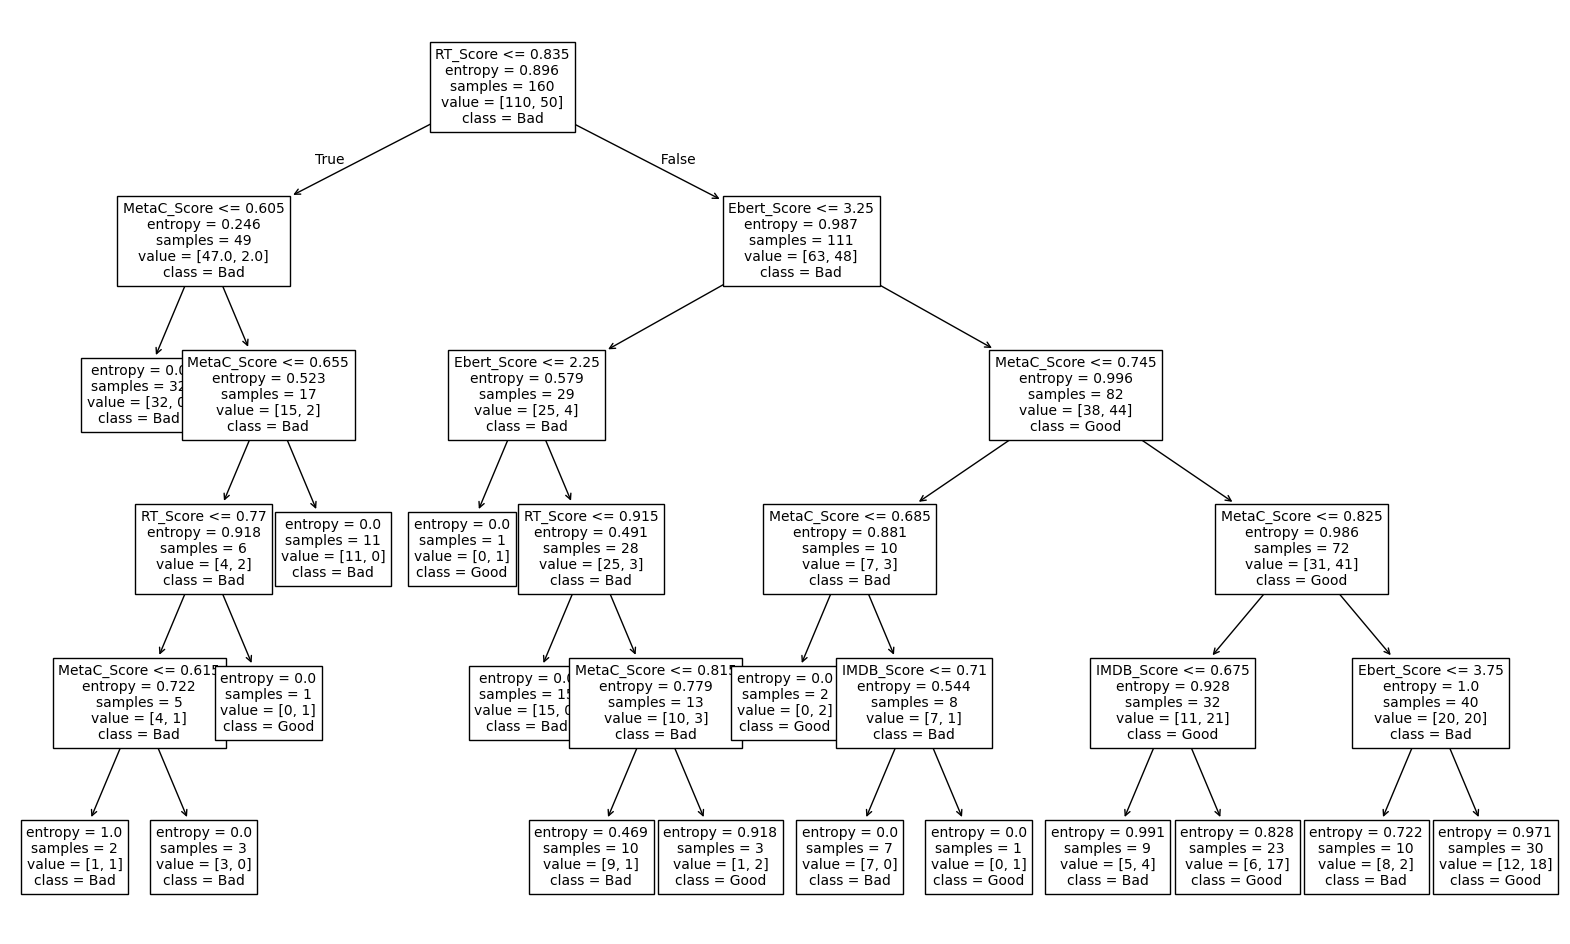

In [28]:
plt.figure(figsize=(20,12))
plot_tree(DT_1, feature_names=X1.columns, class_names=['Bad', 'Good'], fontsize=10)
plt.show()

## For Future Analysis
### Analyzing the high-entropy, high-sample leaf node

There is a leaf node with 40 samples and an entropy of 0.984 . Perhaps drilling down on this node's films might shed light on what additional information could improve the model. Is there a pattern here that might separate the fairly awesome films from the awe-less?

In [29]:
df['Rating'] = pd.Categorical(df['Rating'],
                              categories=['GREAT', 'PRETTY AWESOME', 'AWESOME'],
                              ordered=True)

In [30]:
df[(df['Ebert_Score'] > 3.25) & (df['MetaC_Score'] <= 0.885) & (df['RT_Score'] > 0.785) & (df['RT_Score'] <= 0.985) & (df['MetaC_Score'] > 0.69)].sort_values('Rating', ascending=False)

,Title,Year,Rating,IMDB_Score,RT_Score,MetaC_Score,Ebert_Score,anyAwesome
Movie_ID,,,,,,,,
6,If Beale Street Could Talk,2018,AWESOME,0.71,0.95,0.87,4.0,1
86,The Teachers' Lounge,2023,AWESOME,0.74,0.96,0.82,3.5,1
216,Ex Machina,2014,AWESOME,0.77,0.92,0.78,4.0,1
191,Civil War,2024,AWESOME,0.70,0.81,0.75,4.0,1
190,Furiosa: A Mad Max Saga,2024,AWESOME,0.75,0.90,0.79,4.0,1
...,...,...,...,...,...,...,...,...
163,Crazy Rich Asians,2018,NaN,0.69,0.91,0.74,3.5,0
182,Under the Skin,2013,NaN,0.63,0.83,0.83,4.0,0
195,You Were Never Really Here,2017,NaN,0.67,0.89,0.84,4.0,0


### Takeaway: Add Genre data

Though the pattern isn't striking, I wonder if I might be interpreting from this latest query's result disfavor for the romantic movies of this bunch.

In the next notebook, I incorporate genre attributes and then retry the modeling.

## Save classifier to file

In [34]:
curr_dir = os.getcwd()
model_dir = output_dir_relpath + '/Models'
os.makedirs(model_dir, exist_ok=True)

pickled_clf_filename = '2_MyOwnRatings__DT.pickle'
file_path = os.path.join(model_dir, pickled_clf_filename)

with open(file_path, 'wb') as file:
    pickle.dump(DT_1, file)